# Donkey Kong con PPO (CNN) — Aprendizaje por Refuerzo

## Objetivos de este Notebook

En este notebook aprenderás:

1. **CNN para Atari**: Cómo procesar frames de píxeles (210x160 RGB) con redes convolucionales
2. **Preprocessing**: Escala de grises, redimensionado a 84x84, apilado de 4 frames
3. **PPO (Proximal Policy Optimization)**: Algoritmo de Policy Gradient con clipping
4. **Actor-Critic**: Red con backbone compartido y cabezas separadas para política y valor
5. **Entrenamiento paralelo**: 8 entornos simultáneos para más datos por update

---

## Prerequisitos

- Conceptos básicos de Policy Gradient y Actor-Critic
- PyTorch básico (CNNs)
- Gymnasium / ALE (Arcade Learning Environment)

## Diferencia con el notebook DQN

| Aspecto | DQN (donkey_kong_agent) | PPO (este notebook) |
|---------|------------------------|---------------------|
| Observación | RAM (128 bytes) | Píxeles (84x84x4) |
| Red | MLP | CNN |
| Algoritmo | Double DQN (off-policy) | PPO (on-policy) |
| Replay Buffer | Sí (50K experiencias) | No (usa rollouts) |
| Entornos | 1 | 8 en paralelo |

## 2. Imports y Configuración

In [3]:
import gymnasium as gym
import ale_py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import cv2
import time
from collections import deque

gym.register_envs(ale_py)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Device: cuda
GPU: NVIDIA RTX A4000 Laptop GPU


## 3. Hiperparámetros

Donkey Kong tiene **18 acciones** (vs 4 de Breakout) y rewards más esparsos,
por lo que necesitamos rollouts más largos y más epochs de actualización.

In [4]:
# Entorno
ENV_ID = 'ALE/DonkeyKong-v5'
NUM_ENVS       = 8          # Entornos en paralelo
FRAME_STACK    = 4          # Frames apilados como input
FRAME_SIZE     = 84         # Redimensionar a 84x84

# PPO
TOTAL_TIMESTEPS   = 1_000_000
ROLLOUT_STEPS     = 128        # Pasos por env antes de update
NUM_EPOCHS        = 4          # Epochs por update de PPO
MINIBATCH_SIZE    = 256
GAMMA             = 0.99
GAE_LAMBDA        = 0.95
CLIP_EPSILON      = 0.1
ENTROPY_COEF      = 0.01
VALUE_COEF        = 0.5
MAX_GRAD_NORM     = 0.5
LR                = 2.5e-4
LR_ANNEAL         = True      # Reducir LR linealmente a 0

# Logging y checkpoints
LOG_INTERVAL      = 5
SAVE_INTERVAL     = 50
CHECKPOINT_PATH   = 'donkey_kong_ppo.pth'

batch_size  = NUM_ENVS * ROLLOUT_STEPS
num_updates = TOTAL_TIMESTEPS // batch_size
print(f'Batch size: {batch_size}')
print(f'Updates totales: {num_updates}')
print(f'Timesteps reales: {num_updates * batch_size:,}')

Batch size: 1024
Updates totales: 976
Timesteps reales: 999,424


## 4. Wrapper del Entorno

Preprocesamos los frames de Donkey Kong:

```
Frame RGB (210x160x3)  →  Escala de grises (210x160)  →  Resize (84x84)  →  Apilar 4 frames (4x84x84)
```

A diferencia de Breakout, Donkey Kong **no necesita pulsar FIRE para empezar**.

In [ ]:
class DonkeyKongWrapper(gym.Wrapper):
    """Preprocessing Atari para Donkey Kong:
       - Escala de grises + redimensionar a 84x84
       - Apilar 4 frames consecutivos
       - Recortar recompensas a [-1, 1]
    """
    def __init__(self, env, frame_stack=4, frame_size=84):
        super().__init__(env)
        self.frame_stack = frame_stack
        self.frame_size  = frame_size
        self.frames      = deque(maxlen=frame_stack)
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(frame_stack, frame_size, frame_size),
            dtype=np.uint8
        )

    def _preprocess(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (self.frame_size, self.frame_size),
                             interpolation=cv2.INTER_AREA)
        return resized

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        frame = self._preprocess(obs)
        for _ in range(self.frame_stack):
            self.frames.append(frame)
        return np.stack(self.frames, axis=0), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        frame = self._preprocess(obs)
        self.frames.append(frame)
        stacked = np.stack(self.frames, axis=0)
        reward  = np.clip(reward, -1.0, 1.0)
        return stacked, reward, terminated, truncated, info


def make_env(seed=0, render_mode=None):
    def _init():
        env = gym.make(ENV_ID, render_mode=render_mode)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = DonkeyKongWrapper(env, FRAME_STACK, FRAME_SIZE)
        env.reset(seed=seed)
        return env
    return _init


# Crear entornos vectorizados (sin render para entrenar rapido)
envs = gym.vector.SyncVectorEnv([make_env(seed=i) for i in range(NUM_ENVS)])
n_actions = envs.single_action_space.n
obs_shape = envs.single_observation_space.shape
print(f'Observation shape: {obs_shape}, Actions: {n_actions}')

## 5. Red Neuronal (CNN Actor-Critic)

Arquitectura compartida con cabezas separadas:

```
Input [4x84x84]
    │
    ├─ Conv2d(4, 32, 8x8, stride=4)  →  ReLU  →  [32x20x20]
    ├─ Conv2d(32, 64, 4x4, stride=2) →  ReLU  →  [64x9x9]
    ├─ Conv2d(64, 64, 3x3, stride=1) →  ReLU  →  [64x7x7]
    ├─ Flatten                        →          [3136]
    ├─ Linear(3136, 512)              →  ReLU  →  [512]
    │
    ├─ Actor:  Linear(512, 18) → Softmax → Probabilidad de cada acción
    └─ Critic: Linear(512, 1)            → Valor del estado V(s)
```

In [6]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer


class PPONetwork(nn.Module):
    """CNN compartida con cabezas Actor y Critic separadas."""
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.cnn = nn.Sequential(
            layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, FRAME_SIZE, FRAME_SIZE)
            cnn_out = self.cnn(dummy).shape[1]

        self.fc = nn.Sequential(
            layer_init(nn.Linear(cnn_out, 512)),
            nn.ReLU(),
        )
        self.actor  = layer_init(nn.Linear(512, n_actions), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1),         std=1.0)

    def forward(self, x):
        x = self.cnn(x.float() / 255.0)
        x = self.fc(x)
        return self.actor(x), self.critic(x)

    def get_value(self, x):
        _, value = self.forward(x)
        return value

    def get_action_and_value(self, x, action=None):
        logits, value = self.forward(x)
        dist = Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value


model = PPONetwork(FRAME_STACK, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, eps=1e-5)

total_params = sum(p.numel() for p in model.parameters())
print(model)
print(f'\nParametros totales: {total_params:,}')

PPONetwork(
  (cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
  )
  (actor): Linear(in_features=512, out_features=18, bias=True)
  (critic): Linear(in_features=512, out_features=1, bias=True)
)

Parametros totales: 1,693,875


## 6. Bucle de Entrenamiento PPO

El proceso por cada update:

1. **Rollout**: Recoger 128 pasos x 8 envs = 1024 experiencias
2. **GAE**: Calcular ventajas con Generalized Advantage Estimation
3. **Update**: Actualizar la red con clipping de PPO durante 4 epochs
4. **Checkpoint**: Guardar periodicamente

In [ ]:
# Buffers de almacenamiento
obs_buf      = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + obs_shape, dtype=torch.uint8).to(device)
actions_buf  = torch.zeros((ROLLOUT_STEPS, NUM_ENVS), dtype=torch.long).to(device)
logprobs_buf = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
rewards_buf  = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
dones_buf    = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
values_buf   = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

# Tracking
episode_rewards = []
update_losses   = []
global_step     = 0
start_time      = time.time()

# Reset inicial
next_obs, _ = envs.reset(seed=42)
next_obs  = torch.tensor(next_obs, dtype=torch.uint8).to(device)
next_done = torch.zeros(NUM_ENVS).to(device)

print(f'Iniciando entrenamiento: {num_updates} updates ({TOTAL_TIMESTEPS:,} timesteps)...')
print(f'Sin renderizado visual (solo entrenamiento)\n')

for update in range(1, num_updates + 1):

    # -- LR annealing --
    if LR_ANNEAL:
        frac = 1.0 - (update - 1) / num_updates
        for param_group in optimizer.param_groups:
            param_group['lr'] = frac * LR

    # -- Rollout --
    for step in range(ROLLOUT_STEPS):
        global_step += NUM_ENVS
        obs_buf[step]   = next_obs
        dones_buf[step] = next_done

        with torch.no_grad():
            action, logprob, _, value = model.get_action_and_value(next_obs)
        actions_buf[step]  = action
        logprobs_buf[step] = logprob
        values_buf[step]   = value.flatten()

        next_obs_np, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards_buf[step] = torch.tensor(reward).to(device)
        next_obs  = torch.tensor(next_obs_np, dtype=torch.uint8).to(device)
        next_done = torch.tensor(done, dtype=torch.float32).to(device)

        # Tracking de episodios (gymnasium 1.x format)
        if '_episode' in info:
            for i, done_flag in enumerate(info['_episode']):
                if done_flag:
                    episode_rewards.append(float(info['episode']['r'][i]))

    # -- GAE --
    with torch.no_grad():
        next_value = model.get_value(next_obs).flatten()
        advantages = torch.zeros_like(rewards_buf).to(device)
        last_gae   = 0
        for t in reversed(range(ROLLOUT_STEPS)):
            if t == ROLLOUT_STEPS - 1:
                nextnonterminal = 1.0 - next_done
                nextvalue       = next_value
            else:
                nextnonterminal = 1.0 - dones_buf[t + 1]
                nextvalue       = values_buf[t + 1]
            delta    = rewards_buf[t] + GAMMA * nextvalue * nextnonterminal - values_buf[t]
            last_gae = delta + GAMMA * GAE_LAMBDA * nextnonterminal * last_gae
            advantages[t] = last_gae
        returns = advantages + values_buf

    # -- Flatten batch --
    b_obs        = obs_buf.reshape((-1,) + obs_shape)
    b_actions    = actions_buf.reshape(-1)
    b_logprobs   = logprobs_buf.reshape(-1)
    b_advantages = advantages.reshape(-1)
    b_returns    = returns.reshape(-1)
    b_values     = values_buf.reshape(-1)

    # -- PPO update --
    indices      = np.arange(batch_size)
    clip_fracs   = []
    epoch_losses = []

    for epoch in range(NUM_EPOCHS):
        np.random.shuffle(indices)
        for start in range(0, batch_size, MINIBATCH_SIZE):
            mb_idx = indices[start:start + MINIBATCH_SIZE]

            _, new_logprob, entropy, new_value = model.get_action_and_value(
                b_obs[mb_idx], b_actions[mb_idx]
            )

            log_ratio = new_logprob - b_logprobs[mb_idx]
            ratio     = log_ratio.exp()

            with torch.no_grad():
                clip_fracs.append(((ratio - 1).abs() > CLIP_EPSILON).float().mean().item())

            mb_adv = b_advantages[mb_idx]
            mb_adv = (mb_adv - mb_adv.mean()) / (mb_adv.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_adv * ratio
            pg_loss2 = -mb_adv * torch.clamp(ratio, 1 - CLIP_EPSILON, 1 + CLIP_EPSILON)
            pg_loss  = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            new_value = new_value.flatten()
            v_clipped = b_values[mb_idx] + torch.clamp(
                new_value - b_values[mb_idx], -CLIP_EPSILON, CLIP_EPSILON
            )
            vf_loss = 0.5 * torch.max(
                (new_value - b_returns[mb_idx]).pow(2),
                (v_clipped - b_returns[mb_idx]).pow(2)
            ).mean()

            # Entropy bonus
            entropy_loss = entropy.mean()

            loss = pg_loss + VALUE_COEF * vf_loss - ENTROPY_COEF * entropy_loss

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            epoch_losses.append(loss.item())

    update_losses.append(np.mean(epoch_losses))

    # -- Logging --
    if update % LOG_INTERVAL == 0:
        elapsed  = time.time() - start_time
        sps      = int(global_step / elapsed)
        mean_rew = np.mean(episode_rewards[-20:]) if episode_rewards else 0.0
        cur_lr   = optimizer.param_groups[0]['lr']
        print(
            f'Update {update:>4}/{num_updates}  '
            f'Steps {global_step:>9,}  '
            f'SPS {sps:>5,}  '
            f'MeanRew {mean_rew:>7.2f}  '
            f'Loss {update_losses[-1]:.4f}  '
            f'LR {cur_lr:.2e}'
        )

    # -- Checkpoint --
    if update % SAVE_INTERVAL == 0:
        torch.save({
            'update':          update,
            'global_step':     global_step,
            'model_state':     model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'episode_rewards': episode_rewards,
            'update_losses':   update_losses,
            'total_updates':   num_updates,
            'hyperparams': {
                'ENV_ID': ENV_ID, 'NUM_ENVS': NUM_ENVS,
                'FRAME_STACK': FRAME_STACK, 'FRAME_SIZE': FRAME_SIZE,
                'ROLLOUT_STEPS': ROLLOUT_STEPS, 'NUM_EPOCHS': NUM_EPOCHS,
                'MINIBATCH_SIZE': MINIBATCH_SIZE, 'GAMMA': GAMMA,
                'GAE_LAMBDA': GAE_LAMBDA, 'CLIP_EPSILON': CLIP_EPSILON,
                'ENTROPY_COEF': ENTROPY_COEF, 'VALUE_COEF': VALUE_COEF,
                'MAX_GRAD_NORM': MAX_GRAD_NORM, 'LR': LR,
                'LR_ANNEAL': LR_ANNEAL, 'n_actions': n_actions,
            },
        }, CHECKPOINT_PATH)
        print(f'  Checkpoint guardado: {CHECKPOINT_PATH}')

envs.close()
print('\nEntrenamiento completado!')

## 7. Curvas de Entrenamiento

/tmp/ipykernel_12896/2293460414.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


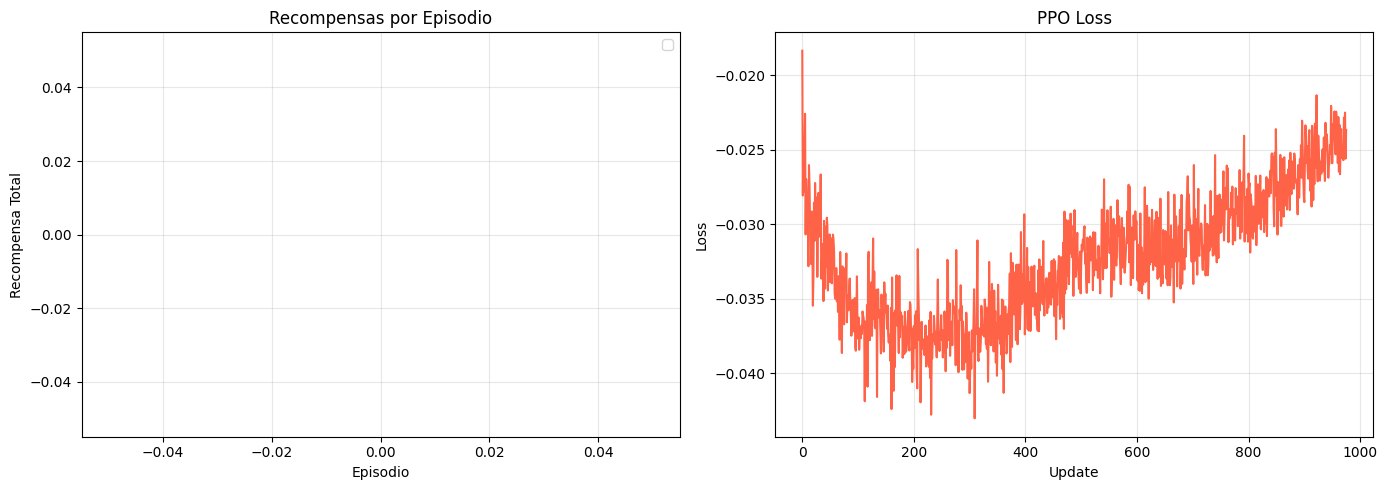

Guardado: donkey_kong_training_curves.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Recompensas por episodio
window = 50
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0].plot(smoothed, color='steelblue', label=f'Media movil ({window} eps)')
axes[0].plot(episode_rewards, alpha=0.3, color='steelblue')
axes[0].set_xlabel('Episodio')
axes[0].set_ylabel('Recompensa Total')
axes[0].set_title('Recompensas por Episodio')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(update_losses, color='tomato')
axes[1].set_xlabel('Update')
axes[1].set_ylabel('Loss')
axes[1].set_title('PPO Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('donkey_kong_training_curves.png', dpi=150)
plt.show()
print('Guardado: donkey_kong_training_curves.png')

## 8. Guardar Checkpoint Final

Este checkpoint contiene todo lo necesario para retomar el entrenamiento desde `train_donkey_kong.py`.

In [10]:
torch.save({
    'update':          num_updates,
    'global_step':     global_step,
    'model_state':     model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'episode_rewards': episode_rewards,
    'update_losses':   update_losses,
    'total_updates':   num_updates,
    'hyperparams': {
        'ENV_ID': ENV_ID, 'NUM_ENVS': NUM_ENVS,
        'FRAME_STACK': FRAME_STACK, 'FRAME_SIZE': FRAME_SIZE,
        'ROLLOUT_STEPS': ROLLOUT_STEPS, 'NUM_EPOCHS': NUM_EPOCHS,
        'MINIBATCH_SIZE': MINIBATCH_SIZE, 'GAMMA': GAMMA,
        'GAE_LAMBDA': GAE_LAMBDA, 'CLIP_EPSILON': CLIP_EPSILON,
        'ENTROPY_COEF': ENTROPY_COEF, 'VALUE_COEF': VALUE_COEF,
        'MAX_GRAD_NORM': MAX_GRAD_NORM, 'LR': LR,
        'LR_ANNEAL': LR_ANNEAL, 'n_actions': n_actions,
    },
}, CHECKPOINT_PATH)

print(f'Checkpoint final guardado: {CHECKPOINT_PATH}')
print(f'Updates completados: {num_updates}')
print(f'Timesteps totales: {global_step:,}')
print(f'Episodios completados: {len(episode_rewards)}')
if episode_rewards:
    print(f'Mejor recompensa: {max(episode_rewards):.1f}')
    print(f'Media ultimos 20: {np.mean(episode_rewards[-20:]):.2f}')
print(f'\nPara continuar entrenando:')
print(f'  python train_donkey_kong.py')
print(f'  python train_donkey_kong.py --updates 200')

Checkpoint final guardado: donkey_kong_ppo.pth
Updates completados: 976
Timesteps totales: 999,424
Episodios completados: 0

Para continuar entrenando:
  python train_donkey_kong.py
  python train_donkey_kong.py --updates 200
